The S1210 airfoil was designed for high lift coefficients at low Reynolds numbers, which seems to be of interest for vertical axis wind turbine applications [1, 2]. A slotted variant for VAWTs was analyzed in a wind tunnel and using CFD [3], where the data for this notebook came from. The experimental data is not really close to the results below (which predict  higher lift and lower drag) nor is the experimental data close to the CFD results in paper. Which, interestingly, predict lower lift and higher drag. Looks like a fully turbulent simulation though.

Regardless, this is an interesting example to show what virtual displacements are good for. They are used to modify smooth geometries to model kinks or otherwise difficult geometries.

In addition, this notebook shows how to interactively plot and show the changes in the solution during the Newton iterations. Tis takes a toll on the runtime, though.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
interactive_plot = True
    
import numpy as np
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import logging
logging.getLogger().setLevel(logging.ERROR)

<IPython.core.display.Javascript object>


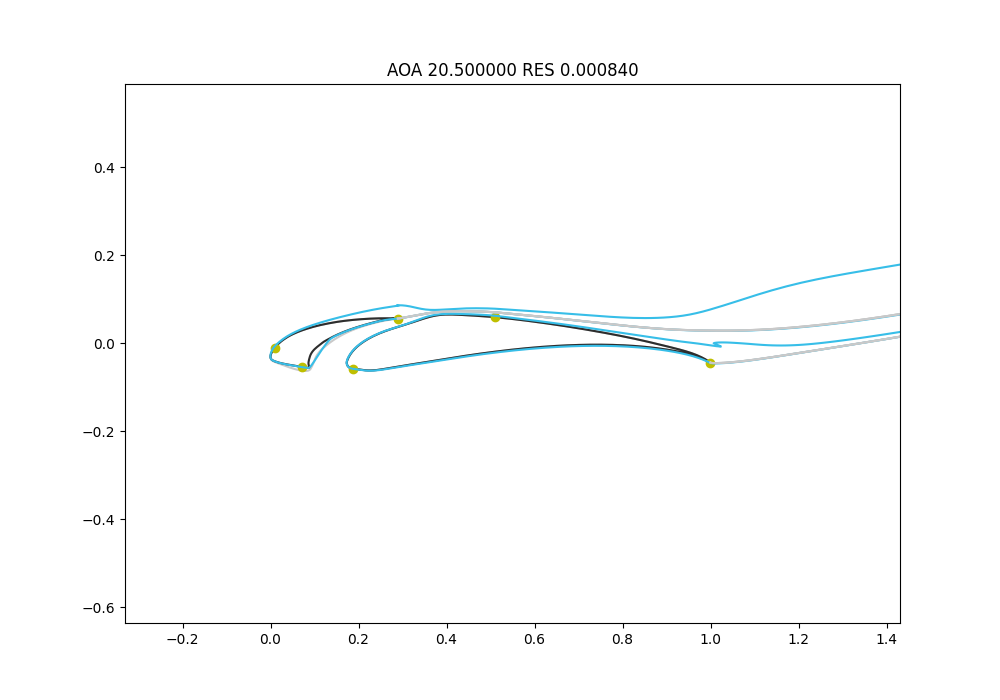

In [2]:
if interactive_plot:
    %matplotlib notebook
    matplotlib.rcParams['figure.figsize'] = [10, 7] 
    lines = None
    fig, ax = plt.subplots(1,1)
else:
    %matplotlib inline
    matplotlib.rcParams['figure.figsize'] = [12, 6]
%config InlineBackend.figure_format = 'svg'

In [3]:
BASE = vft.repanel(vft.read_selig("S1210Base.dat"),230)
SLOT = vft.repanel(vft.read_selig("S1210Slot.dat"),200)
SLOT0 = vft.read_selig("S1210Slot0.dat") # Actual slot shape


# Virtual displacement
[vdSlot,SLOTD] = vft.virtual_displacement_from_geometry(SLOT,SLOT0)
vdSlot[0] = 0.0
vdSlot[-1] = 0.0

AOARANGE = np.arange(5,21,0.5)

# Setup
RE = 200000
ncrit = 9
Mach = 0.0
AOA0 = AOARANGE[0]
s = vf.setup(Re=RE,Ma=Mach,Ncrit=ncrit,Alpha=AOA0)
s.IterateWakes = True
s.Itermax = 1
s.Silent = True
s.Tolerance = 1e-3

BASE[1,:]-=.5
SLOT[1,:]-=.5

# Set-up and initialize based on inviscid panel solution
(p,bl,x) = vf.init([BASE,SLOT],s)

xn = x.copy()
alv = []
clv = []
cdv = []

for alpha in AOARANGE:
    s.Alpha = alpha
    res = None
    grad = None
    for k in range(int(100/s.Itermax)): # Make effectively 100 iterations, but show some in between
        [xn,flag,res,grad,_] = vf.iter(xn,bl,p,s,res,grad,[None,vdSlot])
        # Plot geometry
        if interactive_plot:
            lines = vfp.plot_geometry(ax,p,bl,lines)
        nres=np.sqrt(np.dot(res.T,res))
        title = "AOA %f RES %f"%(alpha,nres)
        ax.set_title(title)
        
        fig.canvas.draw()
        if flag:
            alv.append(alpha)
            clv.append(p.CL)
            cdv.append(bl[0].CD+bl[1].CD)
            print('AL: %f CL: %f CD: %f' % (alpha,clv[-1],cdv[-1]) ) 
            break


c:\users\maxra\scoop\apps\python\current\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
c:\users\maxra\scoop\apps\python\current\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
c:\users\maxra\scoop\apps\python\current\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

AL: 5.000000 CL: 1.445227 CD: 0.029983
AL: 5.500000 CL: 1.495930 CD: 0.029384
AL: 6.000000 CL: 1.547446 CD: 0.028849
AL: 6.500000 CL: 1.598018 CD: 0.028602
AL: 7.000000 CL: 1.646939 CD: 0.028939
AL: 7.500000 CL: 1.695374 CD: 0.029364
AL: 8.000000 CL: 1.742810 CD: 0.030095
AL: 8.500000 CL: 1.788419 CD: 0.031011
AL: 9.000000 CL: 1.833683 CD: 0.032142
AL: 9.500000 CL: 1.879911 CD: 0.033478
AL: 10.000000 CL: 1.924903 CD: 0.034778
AL: 10.500000 CL: 1.968244 CD: 0.036046
AL: 11.000000 CL: 2.011100 CD: 0.037336
AL: 11.500000 CL: 2.054702 CD: 0.038504
AL: 12.000000 CL: 2.097560 CD: 0.039731
AL: 12.500000 CL: 2.138941 CD: 0.041004
AL: 13.000000 CL: 2.179167 CD: 0.042279
AL: 13.500000 CL: 2.220438 CD: 0.043381
AL: 14.000000 CL: 2.261267 CD: 0.044445
AL: 14.500000 CL: 2.301129 CD: 0.045764
AL: 15.000000 CL: 2.341827 CD: 0.048542
AL: 15.500000 CL: 2.384176 CD: 0.053632
AL: 16.000000 CL: 2.427902 CD: 0.058229
AL: 16.500000 CL: 2.464397 CD: 0.063552
AL: 17.000000 CL: 2.507542 CD: 0.068895
AL: 17.500

<IPython.core.display.Javascript object>


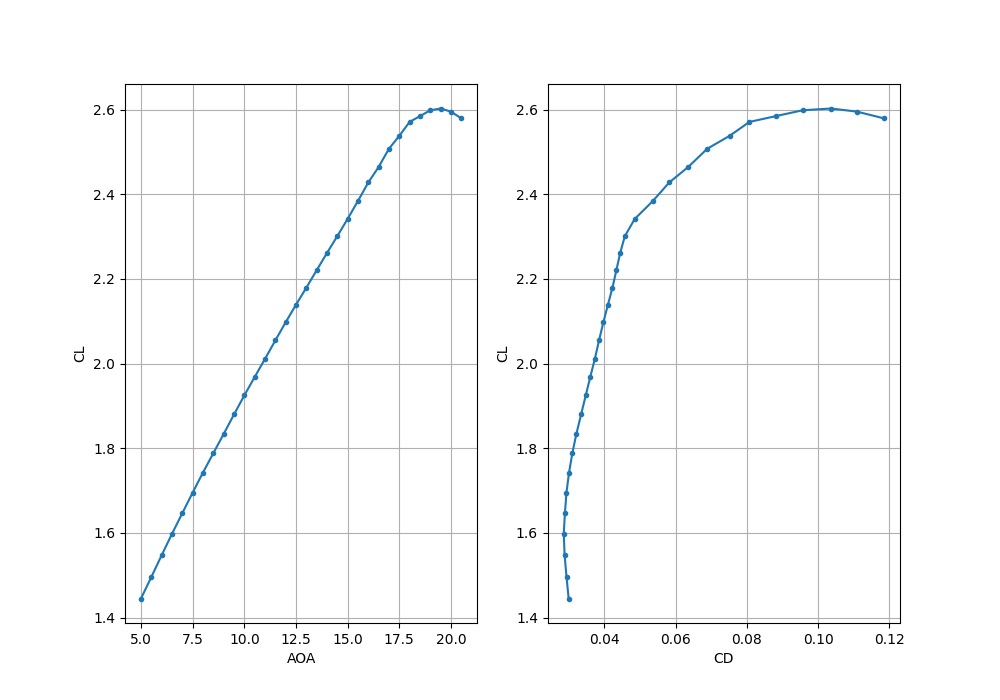

In [4]:
# Make a new plot with the results
fig,ax = plt.subplots(1,2)
ax[0].plot(alv,clv,marker=".")
ax[0].set_xlabel('AOA')
ax[0].set_ylabel('CL')
ax[0].grid(1)
ax[1].plot(cdv,clv,marker=".")
ax[1].set_xlabel('CD')
ax[1].set_ylabel('CL');
ax[1].grid(1)

[1] Islam, Mazharul, et al. *Investigation of low reynolds number airfoils for fixed-pitch straight-bladed VAWT.* 47th AIAA Aerospace Sciences Meeting including The New Horizons Forum and Aerospace Exposition. 2009.

[2] Singh, M. A., A. Biswas, and R. D. Misra. *Investigation of self-starting and high rotor solidity on the performance of a three S1210 blade H-type Darrieus rotor.* Renewable energy 76 (2015): 381-387.

[3] Chougule, Prasad, and Søren RK Nielsen. *Simulation of flow over double-element airfoil and wind tunnel test for use in vertical axis wind turbine.* Journal of Physics: Conference Series. Vol. 524. No. 1. IOP Publishing, 2014.